In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from compound import (
    get_compound_return, 
    simulate_compound_return,
    build_dataframe,
    MONTHS_IN_YEAR,
    DEFAULT_RETIREMENT_YEARS,
    define_scenario
)

### Case of time evolution of loan and rental earnings

Total contribution to loans 7076.550989254261
Earnings through loan investment 262796.3080289923
Earnings through house renting 648000
Loan earnings per contribution 37.13621345031618

Years to reach loan and rental earnings equality 29
Years to reach loan and rental accumulated earnings equality 0


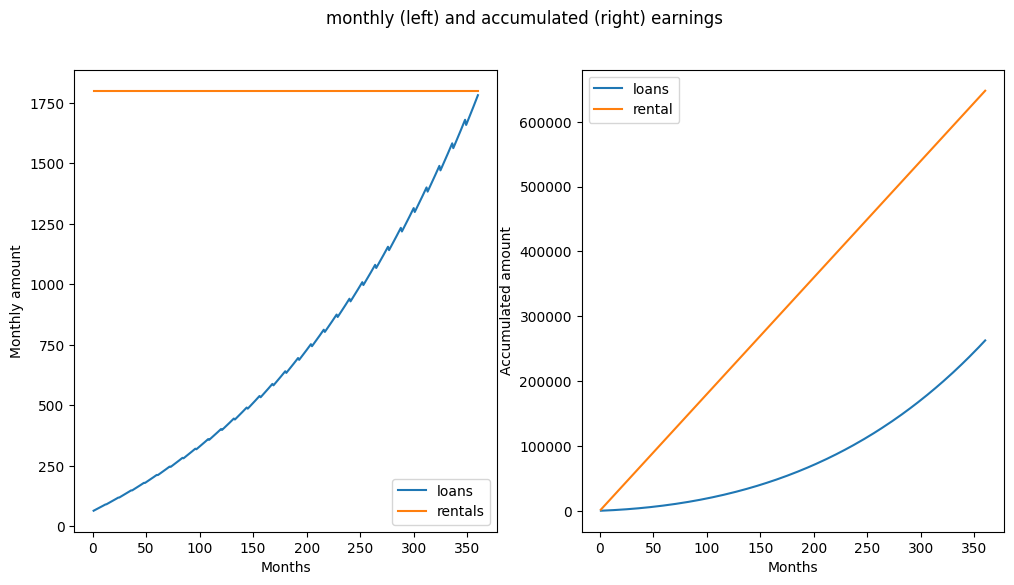

In [45]:
# common parameters
duration = 30
months = np.arange(12 * duration) + 1
rental_accum = 0
rental_month = 1800
retirement_at = 0
retirement_income = 1500
retirement_contribution = 50
rental_accum_income = []
rental_income_history = []

# Investment Parameters
principal_amount = 10_000
annual_contribution = 300 * 12  # 50 * 12
roi = 0.08
term_frequency = 1
periodic_contribution = annual_contribution / term_frequency
rental_accum = 0

inc_contribution = 0.01
inflation_rate = 0.02
tax_rate = 0.25
retirement_contribution_rate = 0.1

# Calculate cumulative rental income
for month in months:
    rental_accum += rental_month
    rental_income_history.append(rental_month)

#  Calculate ROI using the `calculate_return_on_investment` function
total_loan_balance, info_sim = simulate_compound_return(
    principal=principal_amount,
    annual_roi=roi,
    yield_frequency=term_frequency,
    annual_contribution=periodic_contribution,
    inc_contribution_rate=inc_contribution,
    investment_duration=duration,
    retirement_at=0,
    inflation_rate=inflation_rate,
    tax=tax_rate,
    return_series=True
)

# Stats
loan_earnings = info_sim["net_earnings"]
total_loan_earnings = sum(loan_earnings)
total_loan_contribution = total_loan_balance - total_loan_earnings
earning_per_contribution = total_loan_earnings / total_loan_contribution

# Months to equality
month_equal_earnings = np.abs(np.array(loan_earnings) - np.array(rental_income_history)).argmin()
month_equal_accum_earnings = np.abs(np.cumsum(loan_earnings) - np.cumsum(rental_income_history)).argmin()

print(f"Total contribution to loans {total_loan_contribution}")
print(f"Earnings through loan investment {total_loan_earnings}")
print(f"Earnings through house renting {sum(rental_income_history)}")
print(f"Loan earnings per contribution {earning_per_contribution}", end=2*"\n")

# ======================== #

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

plt.plot(months, loan_earnings, label="loans")
plt.plot(months, rental_income_history, label="rentals")
plt.xlabel("Months")
plt.ylabel("Monthly amount")
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(months, np.cumsum(loan_earnings), label="loans")
plt.plot(months, np.cumsum(rental_income_history), label="rental")
plt.xlabel("Months")
plt.ylabel("Accumulated amount")
plt.legend()
#print(plt.xticks())
#x_locs, x_labels = plt.xticks()
#plt.xticks(ticks=x_locs, labels=x_labels)

_ = fig.suptitle("monthly (left) and accumulated (right) earnings")

print(f"Years to reach loan and rental earnings equality {month_equal_earnings // 12}")
print(f"Years to reach loan and rental accumulated earnings equality {month_equal_accum_earnings // 12}")

In [44]:
60 * 12

720

In [43]:
x = x_labels[0]
x.set_x(11)
x.set_y(117)
x

Text(11, 117, '−50')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

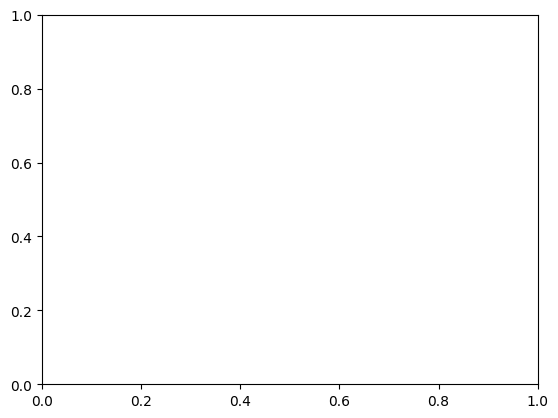

In [9]:
len(loan_earnings)

360

See how loan-investment-vehicle overcomes rental case after ~ 30 years.

## Simulation of scenarios to find equality of loan and rental earnings

In [14]:
scenarios = {}
# Time
durations = np.arange(10, 50 + 15, 5)
monthly_rental_incomes = np.arange(600, 2000 + 100, 100)
# Income
principal_amount = 10_000
monthly_rental_income = 1800
# Roi
rois = np.arange(0.04, 0.12 + 0.01, 0.01)
annual_contributions = 12 * np.arange(50, 300, 50)
inc_contributions = 0.01
terms = 1
warmup_months = 12
inflation_rate = 0.02
tax_rate = 0.25
retirement_contribution_rate = 0.1

for duration in durations:
    for monthly_rental_income in monthly_rental_incomes:
        rental_income = np.repeat(monthly_rental_income, 12 * duration)
        accumulated_rental_income = np.cumsum(rental_income)
        for roi in rois:
            for annual_contribution in annual_contributions:
                # Loan simulation
                total, info_sim = simulate_compound_return(
                    principal=principal_amount,
                    annual_roi=roi,
                    yield_frequency=term_frequency,
                    annual_contribution=annual_contribution,
                    inc_contribution_rate=inc_contribution,
                    investment_duration=duration,
                    retirement_at=0,
                    inflation_rate=inflation_rate,
                    tax=tax_rate,
                    return_series=True
                )
                balance = info_sim["balances"]
                earnings = info_sim["net_earnings"]
                
                # Estimate months until loan and rental earnings are approximately equal
                years_to_equality = np.abs(np.cumsum(earnings) - accumulated_rental_income)[warmup_months:].argmin() / 12
                
                scenarios[(duration, monthly_rental_income, roi, annual_contribution)] = years_to_equality

In [15]:
multi_index = pd.MultiIndex.from_tuples(list(scenarios.keys()), names=["duration",
                                                                       "rental_income",
                                                                       "roi",
                                                                       "annual_contribution"])

df_years = pd.DataFrame(data=list(scenarios.values()),
                        index=multi_index,
                        columns=["years_to_equality"]
                       ) \
             .astype(int) \
             .replace(0, np.nan) \
             .dropna() \
             .sort_values("years_to_equality",
                          ascending=True
                         ) \
             .sort_values("roi", 
                          axis=0,
                          ascending=True,
                         )
df_years

years_to_equality
duration rental_income roi  annual_contribution                   
60       700           0.05 3000                              57.0
55       600           0.05 3000                              51.0
60       600           0.05 2400                              58.0
                            3000                              51.0
50       600           0.06 2400                              46.0
...                                                            ...
         1000          0.12 1200                              33.0
40       1900          0.12 3000                              33.0
         1000          0.12 1200                              33.0
50       700           0.12 600                               32.0
55       1800          0.12 2400                              35.0

[1493 rows x 1 columns]

In [46]:
df_years["equal_at_10_years"] = df_years["years_to_equality"].between(1, 10)
df_years["equal_at_15_years"] = df_years["years_to_equality"].between(1, 15)
df_years["equal_at_20_years"] = df_years["years_to_equality"].between(1, 20)
df_years["equal_at_30_years"] = df_years["years_to_equality"].between(1, 30)
df_years["equal_at_40_years"] = df_years["years_to_equality"].between(1, 40)
df_years

years_to_equality  \
duration rental_income roi  annual_contribution                      
60       700           0.05 3000                              57.0   
55       600           0.05 3000                              51.0   
60       600           0.05 2400                              58.0   
                            3000                              51.0   
50       600           0.06 2400                              46.0   
...                                                            ...   
         1000          0.12 1200                              33.0   
40       1900          0.12 3000                              33.0   
         1000          0.12 1200                              33.0   
50       700           0.12 600                               32.0   
55       1800          0.12 2400                              35.0   

                                                 equal_at_10_years  \
duration rental_income roi  annual_contribution                      
60       700           0.05 3000                             False   
55       600           0.05 3000                             False   
60       600           0.05 2400                             False   
                            3000                             False   
50       600           0.06 2400                             False   
...                                                            ...   
         1000          0.12 1200                             False   
40       1900          0.12 3000                             False   
         1000          0.12 1200                             False   
50       700           0.12 600                              False   
55       1800          0.12 2400                             False   

                                                 equal_at_15_years  \
duration rental_income roi  annual_contribution                      
60       700           0.05 3000                             False   
55       600           0.05 3000                             False   
60       600           0.05 2400                             False   
                            3000                             False   
50       600           0.06 2400                             False   
...                                                            ...   
         1000          0.12 1200                             False   
40       1900          0.12 3000                             False   
         1000          0.12 1200                             False   
50       700           0.12 600                              False   
55       1800          0.12 2400                             False   

                                                 equal_at_20_years  \
duration rental_income roi  annual_contribution                      
60       700           0.05 3000                             False   
55       600           0.05 3000                             False   
60       600           0.05 2400                             False   
                            3000                             False   
50       600           0.06 2400                             False   
...                                                            ...   
         1000          0.12 1200                             False   
40       1900          0.12 3000                             False   
         1000          0.12 1200                             False   
50       700           0.12 600                              False   
55       1800          0.12 2400                             False   

                                                 equal_at_30_years  \
duration rental_income roi  annual_contribution                      
60       700           0.05 3000                             False   
55       600           0.05 3000                             False   
60       600           0.05 2400                             False   
                            3000                       

In [47]:
100 * df_years.mean(axis=0)

years_to_equality    3541.929002
equal_at_10_years       0.000000
equal_at_15_years       0.602813
equal_at_20_years       5.626256
equal_at_30_years      32.016075
equal_at_40_years      70.663094
dtype: float64

Takeaways:

+ From grid of parameters presented in this simulation, we found out there are few loan-investments which overcome the rental case in 15 years of investment duration.
+ It isn't until 20 years that some loan-vehicle-investments start to become more worthy than the rental case.

In [48]:
df_years.loc[df_years["equal_at_20_years"]]

,,,,years_to_equality,equal_at_10_years,equal_at_15_years,equal_at_20_years,equal_at_30_years,equal_at_40_years
duration,rental_income,roi,annual_contribution,,,,,,
50,600,0.10,3000,20.0,False,False,True,True,True
40,600,0.10,3000,20.0,False,False,True,True,True
55,600,0.10,3000,20.0,False,False,True,True,True
35,600,0.10,3000,20.0,False,False,True,True,True
45,600,0.10,3000,20.0,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...
60,600,0.12,1800,20.0,False,False,True,True,True
55,600,0.12,1800,20.0,False,False,True,True,True
45,600,0.12,1800,20.0,False,False,True,True,True
